<div align="center">
    <p><font size="6">DS-210: Programming for Data Science</font></p>
    <p><font size="6">Lecture 24</font></p>
</div>



<div align="center"> 
    <p><font size="5">Parrallel and Concurrent Programming</font></p>
</div>

> Note: A1 Lecture 37


# Please Complete Course Evaluation

<div align="center">
<p><font size="5"><a href="https://go.blueja.io/GJQISjY0i0-OfHuuJa-Z9Q">https://go.blueja.io/GJQISjY0i0-OfHuuJa-Z9Q</a></font></p>
</div>



<div align="center">
  <img src="./course-eval-qr-code.png" width="80%">
</div>

# In Class Poll

https://piazza.com/class/m5qyw6267j12cj/post/502


# 1. Styles of Parallel Programming

* Instruction level parallelism (ILP)
  * Done at the hardware level.  CPU determines independent instructions and executes them in parallel! Often assisted by the compiler which arranges instruction so contiguous instructions can be executed concurrently.
* Single Instruction Multiple Data (SIMD)
  * Done at the hardware level. A processor may be able to do, e.g.,  1 Multiply-Accumulate of Int32, but 2 MACs per cycle for Int16 and 4 MACs per cycle of Int8.
* Thread level parallelism
  * Done at the software level.  Programmer or compiler decomposes program onto mostly independent parts and creates separate threads to execute them.
  * **Message passing between threads**
    * When coordination or data exchange needs arise in #3 the coordination and or data exchange happens by explicitly sending messages between threads.
  * **Shared memory between threads**
    * Threads share all the memory and use locks/barriers to coordinate between them (more below).
* Pipeline Parallelism
  * Output of one thread is input to another
* Data parallelism
  * Each thread works on a different part of the data
* Model parallelism (new)
  * Arose due to large ML models where each thread/core has a part of the model and updates its parameters

Rust language supports thread level parallelism primitives.

We'll look at three of them ([3.1](#31-using-threads-in-rust), [3.2](#32-using-message-passing), [3.3](#33-shared-memorystate-concurrency)  ) and mention the other briefly ([3.4](#34-asynchronous-programming-async-await-futures-etc)).

## Processor Scaling and Multicore Architectures

In 1965, Gordon Moore, cofounder of Intel, observed that component count of
processors was doubling about every 2 years.

He predicted that it would continue for at least the next 10 years.

This became known as **"Moore's Law"**.


<div align="center">
  <img src="./The-Number-of-Components-per-Integrated-Function-Moores-Original-Graph-Moore0.png" width="40%">
</div>

In fact it has held up for over 50 years.

<div align="center">
  <img src="./Transistor-Count-over-time.png" width="90%">
</div>

The industry did this by shrinking component size, which also allowed to increase the clock rate.

Up to a point...

Became increasingly difficult to continue to grow the transistor count...

And increasingly difficult to improve single core performance.

The alternative was to start putting more cores in the processor.

<div align="center">
  <img src="./CPU_clock_speed_and_Core_count_Graph.png" width="70%">
</div>

<div align="center">
  <img src="./apple-m4.png" width="60%">
</div>

<div align="center">
  <img src="./intel-xeon-72-core.png" width="50%">
</div>

## How much memory in a NVDA A100 GPU?
* 80 Gbytes of high bandwidth memory  

## What is the size of GPT-4?
* 1.7 trillion parameters, at 4 bytes each, 6.8 TBytes
* 1.7 trillion parameters, at 2 bytes each, 3.4 TBytes  
* So clearly it will not fit in a single GPU memory

# 2. Limits of Parallel Programming

Let an algorithm A have a serial S and a parallel P part.  Then the time to execute G is:

$$T_A = T_{SA} + T_{PA}$$

Running on multiple processors only affects $T_{PA}$

$$T_{A}(n) = T_{SA} + \frac{T_{PA}}{n}$$ 

which as ${n\to\infty}$ becomes $T_{A}(n) = T_{SA}$

So the maximum possible speedup for a program is 

$$\frac{T_{A}}{T_{SA}}$$

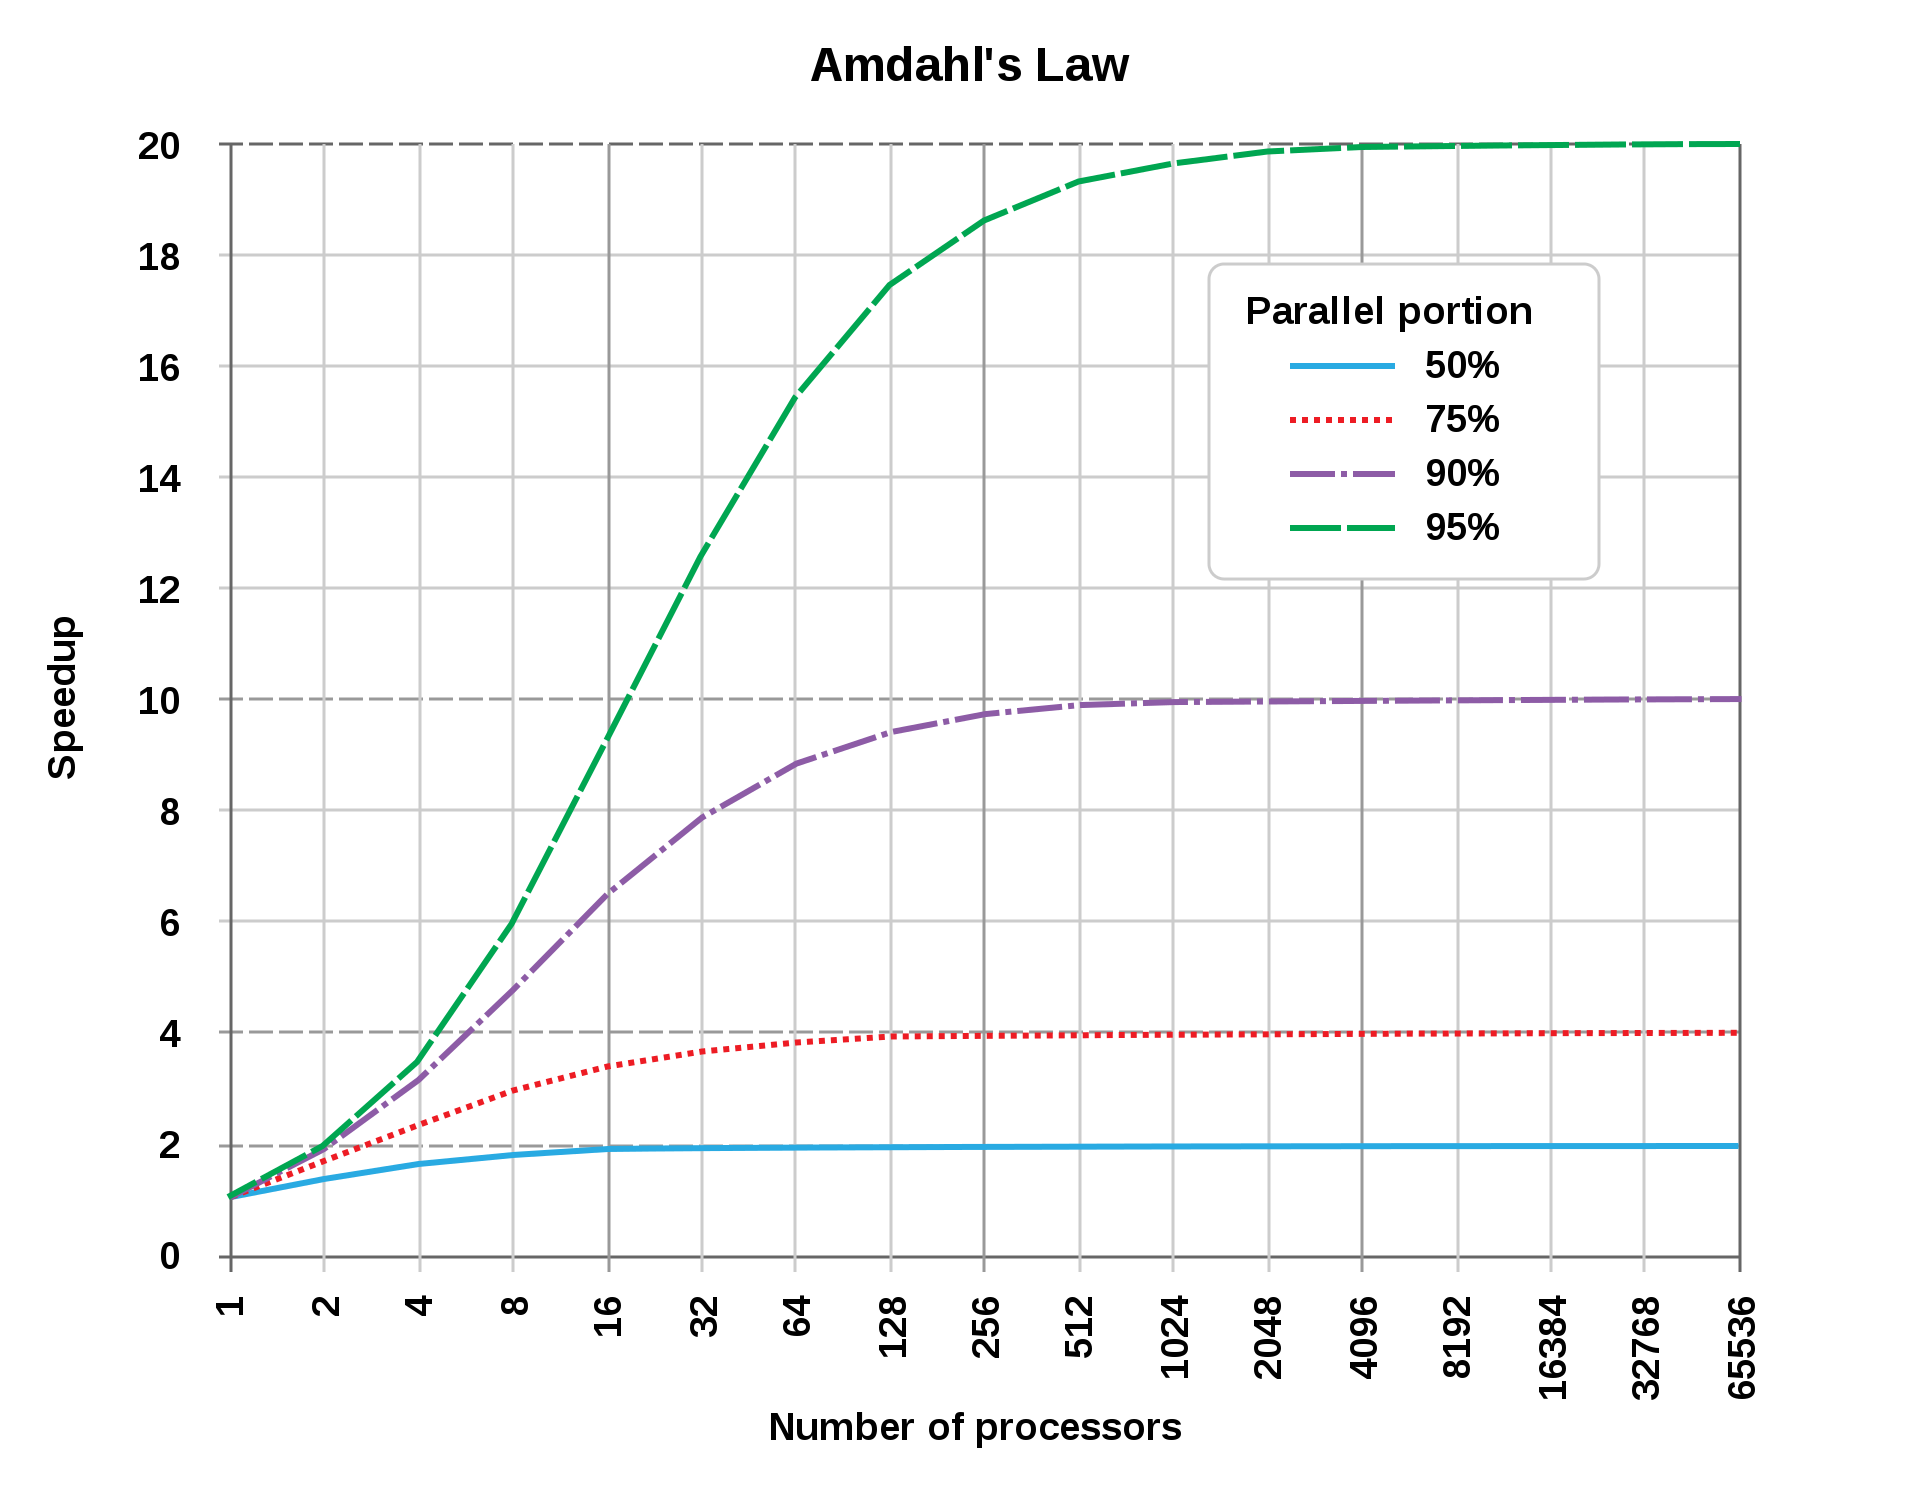

# 3. Rust Parallel and Concurrent Programming 


It helps to look at what constitutes a CPU core and a thread.

Intel processors have typically supported 2 threads/core.

New Mac processors typically support 1 hardware thread/core.

But the OS can support many more SW threads (thousands).

<div align="center">
  <img src="./Architecture-diagram-of-a-multi-core-CPU-processor.png" width="70%">
</div>

Rust libraries provide constructs for different types of parallel/concurrent programming.

1. Threads (`spawn`, `join`)
2. Message Passing Via Channels (`mpsc`)
3. Shared Memory/State Concurrency using Mutexes (`mutex`)
4. Asynchronous Programing with `Async, Await, Futures`, ... [Rust Lang §17](https://doc.rust-lang.org/book/ch17-00-async-await.html)

### 3.1 Using Threads in Rust

Examples from [Rust Language Book, §16.1](https://doc.rust-lang.org/book/ch16-01-threads.html#using-threads-to-run-code-simultaneously).

Rust let's you manually assign program code to additional threads.

Let's "spawn" a thread and print a statement 10 times with a 1 millisecond sleep between iterations.

In [6]:
use std::thread;
use std::time::Duration;

{
    thread::spawn(|| {
        for i in 1..10 {
            println!("hi number {i} from the spawned thread!");
            thread::sleep(Duration::from_millis(1));
        }
    });

    for i in 1..5 {
        println!("hi number {i} from the main thread!");
        thread::sleep(Duration::from_millis(1));
    }
}


hi number 1 from the main thread!
hi number 1 from the spawned thread!
hi number 2 from the main thread!
hi number 2 from the spawned thread!
hi number 3 from the main thread!
hi number 3 from the spawned thread!
hi number 4 from the main thread!
hi number 4 from the spawned thread!
hi number 5 from the spawned thread!


()

Why did we not complete the print loop in the thread?
<br><br><br><br>

The main thread completed and the program shut down.

We can wait till the other thread completes using join handles.

In [7]:
use std::thread;
use std::time::Duration;

{
    // get a handle to the thread
    let handle = thread::spawn(|| {
        for i in 1..10 {
            println!("hi number {i} from the spawned thread!");
            thread::sleep(Duration::from_millis(1));
        }
    });

    for i in 1..5 {
        println!("hi number {i} from the main thread!");
        thread::sleep(Duration::from_millis(1));
    }

    handle.join().unwrap();
}

hi number 6 from the spawned thread!
hi number 7 from the spawned thread!
hi number 8 from the spawned thread!
hi number 9 from the spawned thread!
hi number 1 from the main thread!
hi number 1 from the spawned thread!
hi number 2 from the spawned thread!
hi number 2 from the main thread!
hi number 3 from the spawned thread!
hi number 3 from the main thread!
hi number 4 from the spawned thread!
hi number 4 from the main thread!
hi number 5 from the spawned thread!
hi number 6 from the spawned thread!
hi number 7 from the spawned thread!
hi number 8 from the spawned thread!
hi number 9 from the spawned thread!


()

In [9]:
use std::thread;

{
    let v = vec![1, 2, 3];

    let handle = thread::spawn(move || {
        println!("Here's a vector: {v:?}");
    });

    handle.join().unwrap();
}

Here's a vector: [1, 2, 3]


()

### 3.2 Using Message Passing


Message passing via channels.

Each channel has a Transmitter (tx) and Reciever (Rx).

`std::sync::mpsc` -- Multiple Producer, Single Consumer

Example with single producer, single consumer.

In [11]:
use std::sync::mpsc;
use std::thread;

{
    let (tx, rx) = mpsc::channel();

    thread::spawn(move || {
        let val = String::from("hi");
        tx.send(val).unwrap();
    });

    let received = rx.recv().unwrap();
    println!("Got: {received}");
}

Got: hi


()

Example with Multiple Producer, SIngle Consumer.

In [12]:
use std::sync::mpsc;
use std::thread;
use std::time::Duration;

{

    let (tx, rx) = mpsc::channel();

    let tx1 = tx.clone();
    thread::spawn(move || {
        let vals = vec![
            String::from("hi"),
            String::from("from"),
            String::from("the"),
            String::from("thread"),
        ];

        for val in vals {
            tx1.send(val).unwrap();
            thread::sleep(Duration::from_secs(1));
        }
    });

    thread::spawn(move || {
        let vals = vec![
            String::from("more"),
            String::from("messages"),
            String::from("for"),
            String::from("you"),
        ];

        for val in vals {
            tx.send(val).unwrap();
            thread::sleep(Duration::from_secs(1));
        }
    });

    for received in rx {
        println!("Got: {received}");
    }

}

Got: hi
Got: more
Got: from
Got: messages
Got: the
Got: for
Got: you
Got: thread


()

### 3.3 Shared Memory/State Concurrency

In [14]:
use std::sync::Mutex;

{
    let m = Mutex::new(5);

    {
        let mut num = m.lock().unwrap();
        *num = 6;
    }

    println!("m = {m:?}");
}

m = Mutex { data: 6, poisoned: false, .. }


()

In [15]:
use std::sync::{Arc, Mutex};
use std::thread;

{
    let counter = Arc::new(Mutex::new(0));
    let mut handles = vec![];

    for _ in 0..10 {
        let counter = Arc::clone(&counter);
        let handle = thread::spawn(move || {
            let mut num = counter.lock().unwrap();

            *num += 1;
        });
        handles.push(handle);
    }

    for handle in handles {
        handle.join().unwrap();
    }

    println!("Result: {}", *counter.lock().unwrap());
}

Result: 10


()

### 3.4 Asynchronous Programming: Async, Await, Futures, etc.



_This material is optional._

Rust (and other languages) have language constructs that abstracts away the particulars
of managing and coordinating threads.

You can use Rust's _asynchronous programming_ features
(see [Rust Book, Ch. 17](https://doc.rust-lang.org/book/ch17-00-async-await.html))
to describe which parts of your program _can execute asynchronously_ and how to 
express dependency points between them.

<div align="center">
  <img src="./trpl17-03.svg" width="70%">

  <p><em>Mixed parallel and concurrent workflow. Fig 17-3 from the Rust Book.</em></p>
</div>

From [Futures and the Async Syntax](https://doc.rust-lang.org/book/ch17-01-futures-and-syntax.html):

* A future is a value that may not be ready now but will become ready at some point in the future.

* You can apply the `async` keyword to blocks and functions to specify that they can be interrupted and resumed. 

* Within an async block or async function, you can use the `await` keyword to await a _future_ 
    * that is, wait for it to become ready. 

* Any point where you await a future within an async block or function is a potential spot for that async block or function to pause and resume. 

* The process of checking with a future to see if its value is available yet is called polling.

See [Rust Book, Ch. 17](https://doc.rust-lang.org/book/ch17-00-async-await.html) to dive deeper.

# Additional Examples (Optional)



## Message passing between threads


- The code demonstrates thread communication using Rust's `mpsc` (multiple producer, single consumer) channels to exchange messages between threads.
- Two worker threads are spawned, each with its own pair of channels for bidirectional communication with the main thread.
- The main thread coordinates the communication by receiving messages from both worker threads and sending responses back to them.
- The code uses thread synchronization primitives like `join()` to ensure proper thread termination and `sleep()` to manage timing.


In [2]:
use std::thread;
use std::sync::mpsc;
use std::time::Duration;


fn communicate(id:i32, tx: mpsc::Sender<String>, rx:mpsc::Receiver<&str>) {
   let t = format!("Hello from thread {}", id);
   tx.send(t).unwrap();
   let a:&str = rx.recv().unwrap();
   println!("Thread {} received {}", id, a);
}

fn main_thread() {

    let (tx1, rx1) = mpsc::channel();
    let (tx2, rx2) = mpsc::channel();
    // let handle1 = 
    let handle1 = thread::spawn(move || {
       communicate(1, tx1, rx2);
    });

    let (tx3, rx3) = mpsc::channel();
    let (tx4, rx4) = mpsc::channel();

    // let handle2 = 
    let handle2 = thread::spawn(move || {
       communicate(2, tx3, rx4);
    });

    let a:String = rx1.recv().unwrap();
    let b:String = rx3.recv().unwrap();
    println!("Main thread got \n{}\n{}\n\n", a, b);
    tx2.send("Hi from main").unwrap();
    tx4.send("Hi from main").unwrap();
    thread::sleep(Duration::from_millis(5000));
    handle1.join().unwrap();
    handle2.join().unwrap();
}

main_thread();

Main thread got 
Hello from thread 1
Hello from thread 2


Thread 1 received Hi from main
Thread 2 received Hi from main


## More example programs

Summarized by ChatGPT.


[parallel_write](../lecture_24_optional_code/parallel_write/)

- Creates a configurable square matrix (default 64x64) and processes it in parallel using Rust's Rayon library
- Divides the matrix into chunks based on the number of specified threads, with each thread processing its assigned chunk
- Uses Rayon's `scope` and `spawn` functions for parallel execution, where each thread writes its ID number to its assigned matrix section
- Includes options to configure matrix size, number of threads, and display the matrix before/after processing


[parallel_locks](../lecture_24_optional_code/parallel_locks/)

- The program demonstrates parallel matrix processing with configurable parameters (matrix size, thread count, and synchronization method) using command-line arguments
- It implements three different synchronization approaches:
  - Exclusive locking using `Mutex`
  - Reader-only access using `RwLock` read locks
  - Writer access using `RwLock` write locks
- The program uses Rust's concurrency primitives:
  - `Arc` for thread-safe shared ownership
  - `Mutex` and `RwLock` for synchronization
  - `thread::spawn` for parallel execution
- Each thread processes a segment of the matrix, calculates a sum, and the program measures and reports the total execution time


[parallel_gaussian](../lecture_24_optional_code/parallel_gaussian/)

- Implements parallel Gaussian elimination using Rayon's parallel iterators (`par_iter_mut`) for both matrix initialization and row elimination operations
- Uses thread-safe random number generation with ChaCha8Rng, where each thread gets its own seeded RNG instance
- Allows configuration of matrix size and number of threads via command-line arguments
- Includes performance timing measurements and optional matrix display functionality


[parallel_game_of_life](../lecture_24_optional_code/parallel_game_of_life/)

- Implements Conway's Game of Life simulation with parallel processing using Rayon's concurrency primitives (`scope` and `spawn`)
- Divides the board into chunks that are processed concurrently by multiple threads, with each thread handling a specific section of the board
- Uses command-line arguments to control simulation parameters (board size, thread count, display options, iteration count, and delay between iterations)
- Includes a glider pattern initialization and visual rendering of the board state, with timing measurements for performance analysis

